In [1]:
import torch
import numpy as np
import sympy as sp
import os, sys
import symbolicregression
import requests
from IPython.display import display

import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

In [2]:
model_path = "model.pt" 
try:
    if not os.path.isfile(model_path): 
        url = "https://dl.fbaipublicfiles.com/symbolicregression/model1.pt"
        r = requests.get(url, allow_redirects=True)
        open(model_path, 'wb').write(r.content)
    if not torch.cuda.is_available():
        model = torch.load(model_path, map_location=torch.device('cpu'))
    else:
        model = torch.load(model_path)
        model = model.cuda()
    print(model.device)
    print("Model successfully loaded!")

except Exception as e:
    print("ERROR: model not loaded! path was: {}".format(model_path))
    print(e)    

cuda:0
Model successfully loaded!


In [4]:
est = symbolicregression.model.SymbolicTransformerRegressor(model=model)

In [5]:
##Example of data

x = np.random.randn(100, 2)
y = x[:,0]**2


In [6]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    est.fit(x, y, verbose = True)

Finished forward in 19.948665142059326 secs
Removed 1/11 skeleton duplicata


In [7]:
import sympy
replace_ops = {"add": "+", "mul": "*", "sub": "-", "pow": "**", "inv": "1/"}

In [8]:
tree = est.tree[0][0]["predicted_tree"]
numexpr_fn = model.env.simplifier.tree_to_numexpr_fn(tree)
y_tilde = numexpr_fn(x)[:, 0]

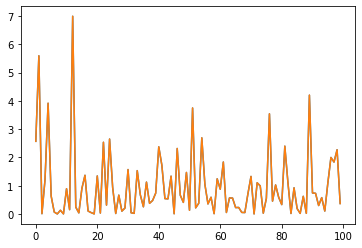

In [9]:
import matplotlib.pyplot as plt
plt.plot(y)
plt.plot(y_tilde)

In [10]:
for i, model_list in enumerate(est.tree[0]):
    if "relabed_predicted_tree" in model_list:
        model_str = model_list["relabed_predicted_tree"].infix()
    else:
        model_str = model_list["predicted_tree"].infix()
    for op,replace_op in replace_ops.items():
        model_str = model_str.replace(op,replace_op)
    expr = sympy.parse_expr(model_str)
    print(expr)
    print('\n')

(0.098845678517330984*x_0 - 0.00038948946588985279)*(1.0158856990475948*x_0 + 0.0050503857565277179)*(0.00307333857555591*sqrt(cos(0.0094212687306583144*x_1 + 0.0016300113803027681) - 0.00099838969404186803) + 9.96)


(0.001982344213902884 - 1.7270056883809111*x_0)*(1.0158856990475948*x_0 - 8.9614243472282577e-5)*(-2.0417740706153e-38*exp((-10.094945584638216*x_1 - 0.58164047141867567)*(0.0079003921966733853*x_1 + 0.065161222977632016) - 51.9*cos((-0.059712266602763966*x_1 - 0.46948598762163729)*(0.0066449035142562963*x_1 + 0.0060579278532796334))) - 0.5720000000000001)


(-0.020317713980951896*x_0 - 0.00010020771513055439)*(-49.47363354361787*x_0 - 0.0010207225060301532*x_1 + 0.25893462412510629)


(0.013420192878765449 - 2.9155919562665972*x_0)*(0.060953141942855693*x_0 + 0.00031062314539166326)*(-0.002878437467005032*x_1 - 5.6601680424802227)


(-3.931477655314192*x_0 - 0.027190192877762266)*(-0.25600319615999389*x_0 + (0.00030596316639267742 - 0.0053792076067789068*x_1)*(-0.0080330

## Sampling Expressions

In [32]:
from symbolicregression.envs.environment import SPECIAL_WORDS
from symbolicregression.envs.generators import RandomFunctions
from parsers import get_parser
import sympy
replace_ops = {"add": "+", "mul": "*", "sub": "-", "pow": "**", "inv": "1/"}

parser = get_parser()
params = parser.parse_args([])
generator = RandomFunctions(params, SPECIAL_WORDS)

In [69]:
m = 2

rng = np.random.RandomState(7)
tree, _, _, _, _ = generator.generate_multi_dimensional_tree(rng, input_dimension = m)

In [70]:
model_str = tree.infix()
for op,replace_op in replace_ops.items():
    model_str = model_str.replace(op, replace_op)
model_str

'(7.11 + (((8.92 * x_1) + ((97.80000000000001 * x_0) + (94.7 * 1/((1.08 + (84.5 * x_1)))))) * ((-0.812 * x_0) + (-76.3 * x_0))))'

In [71]:
expr = sympy.parse_expr(model_str)
expr

-77.112*x_0*(97.80000000000001*x_0 + 8.92*x_1 + 94.7/(84.5*x_1 + 1.08)) + 7.11

In [65]:
npy_str = model_str
for i in range(m):
    npy_str = npy_str.replace(f'x_{i}', f'X[:, {i}]')
npy_str

'(9.5 + (((-62.2 * (X[:, 1] * X[:, 1])) - (-0.78 * X[:, 0])) + (0.246 * X[:, 0])))'